In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import warnings

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from collections import Counter

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("zip_code_age.csv", index_col="Unnamed: 0")
kmeans = pickle.load(open("kmeans.pkl", "rb"))

In [3]:
df.head()

,female_0,female_1,female_2,female_3,female_4,female_5,female_6,female_7,female_8,female_9,...,male_94,male_95,male_96,male_97,male_98,male_99,male_100,male_101,male_102,cluster
10026,216,212,225,189,208,192,190,205,181,195,...,1,1,2,0,0,1,2,1,0,0
10027,354,329,320,323,308,270,291,284,280,284,...,6,3,4,1,2,0,0,0,0,1
10030,167,197,155,191,165,158,150,168,146,150,...,0,1,0,0,0,1,1,0,0,0
10037,81,101,94,93,92,87,64,83,78,83,...,4,4,2,3,1,0,3,0,0,2
10039,184,150,167,152,146,169,152,160,165,178,...,4,0,4,1,0,1,0,0,0,2


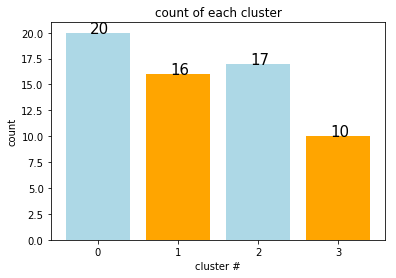

In [4]:
count = Counter(kmeans.best_estimator_.labels_)
x_cluster, y_height = zip(*count.items())

plt.bar(x=x_cluster, height=y_height, tick_label=x_cluster, color=["lightblue", "orange"])
for i, j in count.items(): plt.text(x=i-.1, y=j, s=j, fontdict={"fontsize": 15})
plt.ylabel("count")
plt.xlabel("cluster #")
plt.title("count of each cluster")
plt.show()

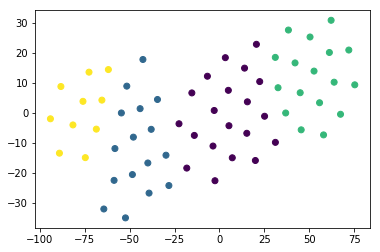

In [20]:
tsne_embedded = TSNE(n_components=2).fit_transform(df)
labels_km4 = kmeans.best_estimator_.labels_
plt.scatter(tsne_embedded[:,0], tsne_embedded[:,1], c=labels_km4)
plt.show()

**Define Age Group as `[0-5 6-12 13-17 18-24 25-34 35-44 45-54 55-64 65+]`**

In [6]:
def generate_age_group_colums(start, end):
    yield from [['female_%s'%age for age in range(start, end+1)], ['male_%s'%age for age in range(start, end+1)]]

In [7]:
age_groups = {(s,e): generate_age_group_colums(s, e)
              for s, e in zip(range(0, 56, 6), range(5, 65, 7))}
age_groups[(65,102)] = generate_age_group_colums(65, 102)

In [8]:
age_groups

{(0, 5): <generator object generate_age_group_colums at 0x1108fca40>,
 (6, 12): <generator object generate_age_group_colums at 0x1108fcaf0>,
 (12, 19): <generator object generate_age_group_colums at 0x1108fcdb0>,
 (18, 26): <generator object generate_age_group_colums at 0x11777a1a8>,
 (24, 33): <generator object generate_age_group_colums at 0x11777a7d8>,
 (30, 40): <generator object generate_age_group_colums at 0x11777a830>,
 (36, 47): <generator object generate_age_group_colums at 0x11777a888>,
 (42, 54): <generator object generate_age_group_colums at 0x11777a8e0>,
 (48, 61): <generator object generate_age_group_colums at 0x11777a938>,
 (65, 102): <generator object generate_age_group_colums at 0x11777a990>}

In [9]:
def create_age_group(df, start, end):
    male_column = "male[%s-%s]" % (start, end)
    female_column = "female[%s-%s]" % (start, end)
    age_group = list(generate_age_group_colums(start, end))
    df[female_column] = np.sum(df[age_group[0]], axis=1)
    df[male_column] = np.sum(df[age_group[1]], axis=1)
    return df

In [10]:
for s, e in age_groups.keys():
    df = create_age_group(df, s, e)

In [11]:
age_group_columns=['%s[%s-%s]'%(g,s,e) for s, e in age_groups.keys() for g in ['female', 'male']]
df_age_gp = df[age_group_columns]
df_age_gp.head()

,female[0-5],male[0-5],female[6-12],male[6-12],female[12-19],male[12-19],female[18-26],male[18-26],female[24-33],male[24-33],female[30-40],male[30-40],female[36-47],male[36-47],female[42-54],male[42-54],female[48-61],male[48-61],female[65-102],male[65-102]
10026,1242,1141,1316,1372,1634,1611,2594,2317,3416,2889,3410,2994,3511,3228,3451,3272,3067,2792,1988,1168
10027,1904,1828,2001,2010,4041,3433,7986,6191,6582,5850,5065,4552,4796,4450,4901,4544,4695,4091,3556,2112
10030,1033,1058,1100,1144,1572,1577,2226,1926,2615,2166,2447,2054,2570,2230,2768,2366,2428,2094,1494,1010
10037,548,504,547,621,816,829,1208,1040,1589,1158,1573,1103,1668,1196,1818,1338,1849,1242,2029,985
10039,968,1035,1142,1198,1457,1453,1819,1714,2200,1722,2268,1818,2287,1956,2398,1936,2180,1580,1834,904


## Distribution of each Cluster

In [76]:
def plot_cluster_distribution(cluster_idx):
    c = kmeans.best_estimator_.labels_==cluster_idx
    plt.bar(age_group_columns, np.sum(df_age_gp[c], axis=0), color=["lightblue", 'orange'])
    plt.xticks(rotation=90)
    plt.ylabel("count")
    plt.title("Distribution of Cluster %s"%cluster_idx)
    plt.ylim([0, 10**5.05])
#     plt.show()

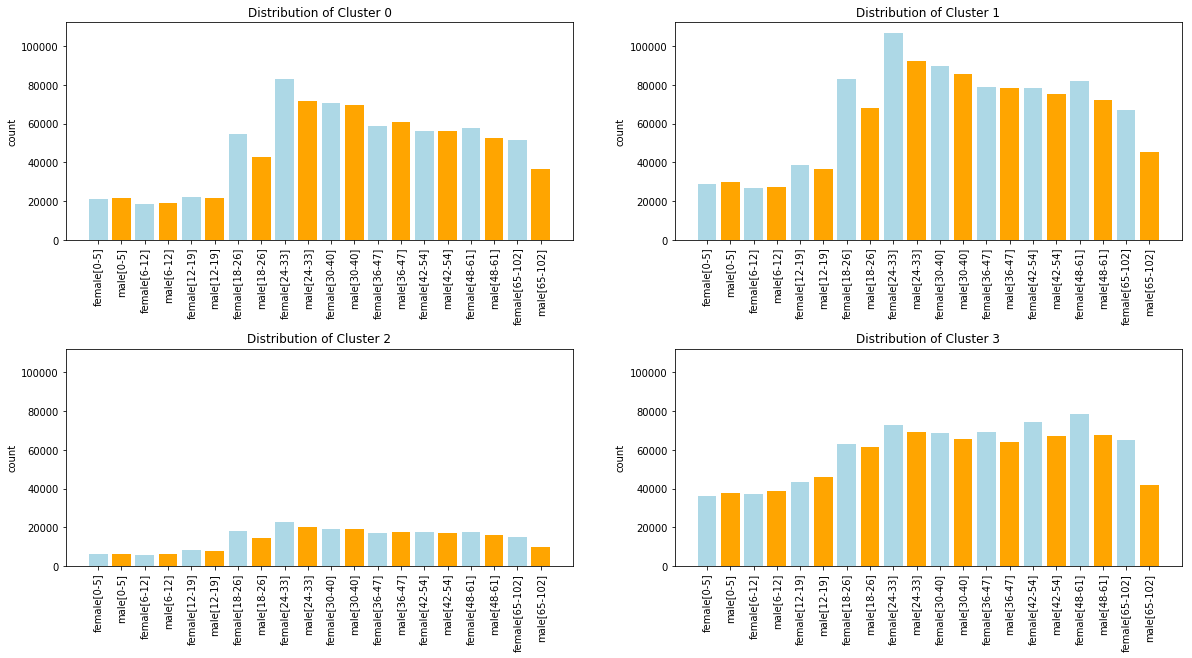

In [77]:
plt.figure(figsize=(20,10))
plt.subplots_adjust(hspace=0.5)
plt.subplot(2,2,1); plot_cluster_distribution(cluster_idx=0)
plt.subplot(2,2,2); plot_cluster_distribution(cluster_idx=1)
plt.subplot(2,2,3); plot_cluster_distribution(cluster_idx=2)
plt.subplot(2,2,4); plot_cluster_distribution(cluster_idx=3)